In [48]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime
import matplotlib.font_manager as fm

# 한글 폰트 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 데이터 로드
df = pd.read_csv('C:\\workspace\\WASSUP4\\data\\mini.csv', sep=',')

# 수치형 변수의 결측치를 중위값으로 대체
imputer = SimpleImputer(strategy='median')
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# 스케일링을 적용할 변수들
scaler = StandardScaler()
scaled_cols = ['subscription_duration', 'average_time_per_learning_session', 'monthly_active_learning_days']
df[scaled_cols] = scaler.fit_transform(df[scaled_cols])

# Label Encoding
label_encoder = LabelEncoder()
df['subscription_type'] = label_encoder.fit_transform(df['subscription_type'])

# 색상 설정
palette = ["#7C80FF", "#D15376"]  # 이미지의 두 가지 색상 코드

# 데이터 필터링
df_subset = df[['subscription_duration', 'average_time_per_learning_session', 'monthly_active_learning_days', 
                'total_completed_courses', 'abandoned_learning_sessions', 'community_engagement_level', 
                'recent_login_time', 'average_login_time', 'recent_learning_achievement', 
                'preferred_difficulty_level', 'target']]

# 날짜/시간 형식 변환
df['recent_login_time'] = pd.to_datetime(df['recent_login_time'])
df['average_login_time'] = pd.to_datetime(df['average_login_time'], errors='coerce')  # NaT로 처리

# datetime 열 처리
df['days_since_last_login'] = (datetime.now() - df['recent_login_time']).dt.days
df['recent_login_days'] = (pd.Timestamp.now() - df['recent_login_time']).dt.total_seconds() / (24 * 60 * 60)
df['average_login_hour'] = df['average_login_time'].dt.hour + df['average_login_time'].dt.minute / 60

# target 열을 제외한 독립 변수와 target을 종속 변수로 설정
X = df.drop(['target', 'recent_login_time', 'average_login_time'], axis=1)
y = df['target']

# 범주형 변수를 원-핫 인코딩으로 변환
X = pd.get_dummies(X, columns=['preferred_difficulty_level', 'subscription_type'], drop_first=True)

# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 로지스틱 회귀 모델 생성 및 학습
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_scaled, y_train)

# 예측 및 평가
y_pred = model.predict(X_test_scaled)
print("혼동 행렬:")
print(confusion_matrix(y_test, y_pred))
print("\n분류 보고서:")
print(classification_report(y_test, y_pred))

# 상관관계 행렬
numeric_df_subset = df.select_dtypes(include=['float64', 'int64', 'int32', 'int8'])
correlation_matrix = numeric_df_subset.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5)
plt.title("변수 간 상관관계 행렬", fontsize=12, fontweight='bold', fontproperties=font_prop)
plt.show()

# 구독 연장 여부에 따른 평균 학습 시간 분포
plt.figure(figsize=(12, 6))
sns.histplot(df[df['target'] == 1]['average_time_per_learning_session'], kde=True, color=palette[0], label='구독 연장')
sns.histplot(df[df['target'] == 0]['average_time_per_learning_session'], kde=True, color=palette[1], label='구독 미연장')
plt.title("구독 연장 여부에 따른 평균 학습 시간 분포", fontsize=12, fontweight='bold', fontproperties=font_prop)
plt.xlabel("평균 학습 시간 (분)", fontproperties=font_prop)
plt.ylabel("빈도수", fontproperties=font_prop)
plt.legend(prop=font_prop)
plt.show()

# 구독 유형에 따른 구독 연장 여부
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='subscription_type', hue='target', palette=palette, width=0.5)
plt.title("구독 유형에 따른 구독 연장 여부", fontsize=12, fontweight='bold', fontproperties=font_prop)
plt.xlabel("구독 유형", fontproperties=font_prop)
plt.ylabel("빈도수", fontproperties=font_prop)
plt.legend(title="구독 연장 여부", labels=["구독 미연장", "구독 연장"], prop=font_prop)
plt.show()

# 커뮤니티 참여도에 따른 구독 연장 여부
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='target', y='community_engagement_level', palette=palette, width=0.5)
plt.title("커뮤니티 참여도에 따른 구독 연장 여부", fontsize=12, fontweight='bold', fontproperties=font_prop)
plt.xlabel("구독 연장 여부", fontproperties=font_prop)
plt.ylabel("커뮤니티 참여도", fontproperties=font_prop)
plt.xticks([0, 1], ["구독 미연장", "구독 연장"], fontproperties=font_prop)
plt.show()

# 페어플롯 생성
continuous_vars = ['subscription_duration', 'average_time_per_learning_session', 'recent_learning_achievement', 'days_since_last_login']
sns.set(style="ticks", font_scale=1.2)
g = sns.pairplot(df[continuous_vars + ['target']], 
                 hue='target', 
                 palette=palette,
                 diag_kind='kde', 
                 plot_kws={'alpha': 0.6},
                 height=3)
g.fig.suptitle("연속형 변수 페어플롯", y=1.02, fontsize=12, fontweight='bold', fontproperties=font_prop)
plt.show()

# 산점도와 회귀선 추가
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='subscription_duration', y='recent_learning_achievement', 
                hue='target', palette=palette, alpha=0.7)
sns.regplot(data=df, x='subscription_duration', y='recent_learning_achievement', 
            scatter=False, color=palette[1])
plt.title('구독 기간 vs 최근 학습 성취도', fontsize=12, fontweight='bold', fontproperties=font_prop)
plt.xlabel('구독 기간', fontsize=12, fontproperties=font_prop)
plt.ylabel('최근 학습 성취도', fontsize=12, fontproperties=font_prop)
plt.legend(title='구독 연장 여부', title_fontsize='12', fontsize='10', prop=font_prop)
plt.show()


ValueError: could not convert string to float: '67b9367b'

t-검정 통계량: -6.921
p-값: 0.000
평균 학습 시간에 대해 두 집단 간의 유의한 차이가 있습니다.


In [35]:
import statsmodels.api as sm

# 독립 변수와 종속 변수 설정
X = basic_users[['average_time_per_learning_session']]
X = sm.add_constant(X)  # 상수항 추가
y = basic_users['target']

# 로지스틱 회귀 모델 생성 및 학습
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# 회귀 분석 결과 출력
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.662448
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 5979
Model:                          Logit   Df Residuals:                     5977
Method:                           MLE   Df Model:                            1
Date:                Mon, 14 Oct 2024   Pseudo R-squ.:                0.005324
Time:                        02:17:37   Log-Likelihood:                -3960.8
converged:                       True   LL-Null:                       -3982.0
Covariance Type:            nonrobust   LLR p-value:                 7.438e-11
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 0.2970      0.038      7

C:\Users\munseoyeon\AppData\Local\Temp\ipykernel_18568\4117619885.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='target', y='average_time_per_learning_session', data=basic_users, palette='Set2')


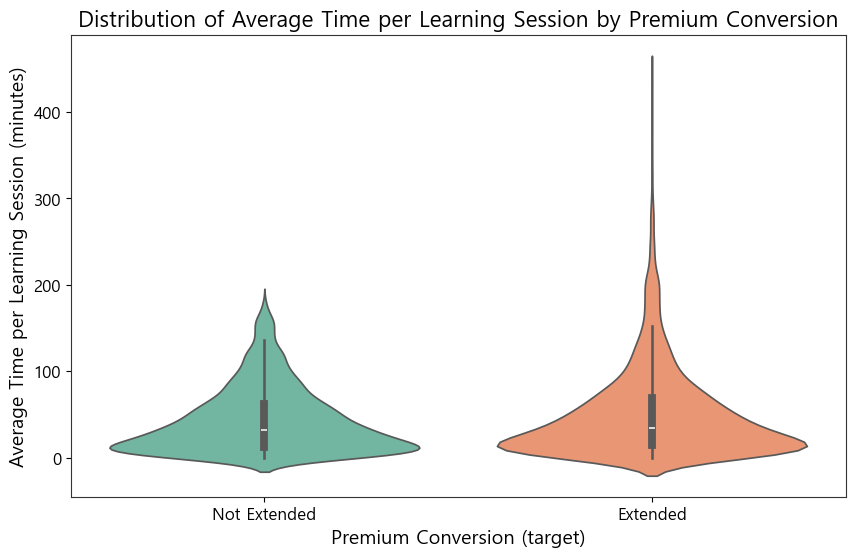

In [36]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='target', y='average_time_per_learning_session', data=basic_users, palette='Set2')
plt.title("Distribution of Average Time per Learning Session by Premium Conversion", fontsize=16)
plt.xlabel("Premium Conversion (target)", fontsize=14)
plt.ylabel("Average Time per Learning Session (minutes)", fontsize=14)
plt.xticks([0, 1], ["Not Extended", "Extended"])
plt.show()


C:\Users\munseoyeon\AppData\Local\Temp\ipykernel_18568\2724547393.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='average_time_per_learning_session', data=basic_users, palette='Set2')


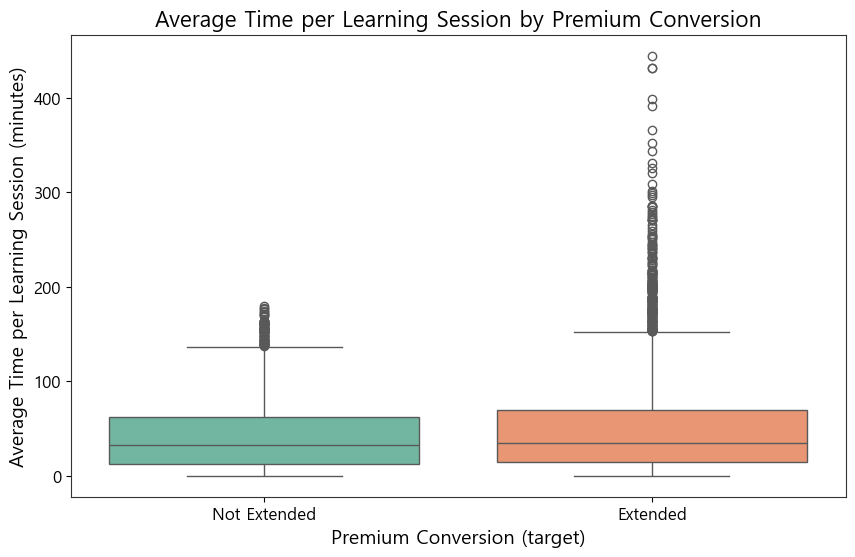

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='average_time_per_learning_session', data=basic_users, palette='Set2')
plt.title("Average Time per Learning Session by Premium Conversion", fontsize=16)
plt.xlabel("Premium Conversion (target)", fontsize=14)
plt.ylabel("Average Time per Learning Session (minutes)", fontsize=14)
plt.xticks([0, 1], ["Not Extended", "Extended"])  # 대상에 맞는 레이블 지정
plt.show()


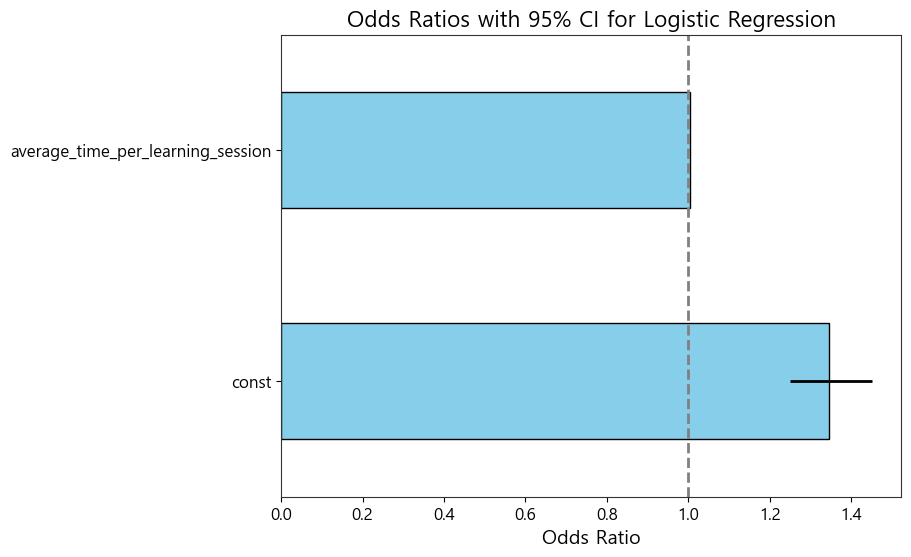

In [38]:
import numpy as np

# odds ratio 계산 및 시각화
params = result.params  # 회귀 계수
conf = result.conf_int()  # 신뢰 구간
conf['Odds Ratio'] = params
conf.columns = ['Lower CI', 'Upper CI', 'Odds Ratio']
odds_ratios = np.exp(conf)

plt.figure(figsize=(8, 6))
odds_ratios['Odds Ratio'].plot(kind='barh', xerr=[odds_ratios['Odds Ratio'] - odds_ratios['Lower CI'], 
                                                  odds_ratios['Upper CI'] - odds_ratios['Odds Ratio']], 
                               color='skyblue', edgecolor='black')
plt.title("Odds Ratios with 95% CI for Logistic Regression", fontsize=16)
plt.xlabel("Odds Ratio", fontsize=14)
plt.axvline(x=1, color='grey', linestyle='--')  # 기준선 추가
plt.show()


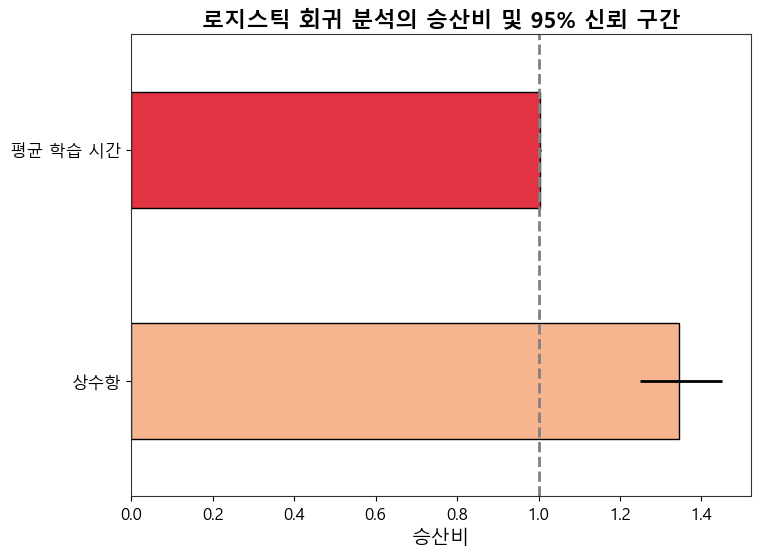

In [44]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 한글 폰트 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 원하는 한글 폰트 경로 설정
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지



# Odds Ratio 계산 및 시각화
params = result.params  # 회귀 계수
conf = result.conf_int()  # 신뢰 구간
conf.columns = ['하한 신뢰 구간', '상한 신뢰 구간']  # 영어로 유지하여 열 이름 변경 문제 방지
conf['승산비'] = params
odds_ratios = np.exp(conf)

# 색상 팔레트 설정
# palette = sns.color_palette("rocket", len(odds_ratios))  # rocket 팔레트의 다양한 색상 사용
p = sns.color_palette("rocket")[::-2]

# 그래프 설정
plt.figure(figsize=(8, 6))
odds_ratios['승산비'].plot(
    kind='barh', 
    xerr=[odds_ratios['승산비'] - odds_ratios['하한 신뢰 구간'], 
          odds_ratios['상한 신뢰 구간'] - odds_ratios['승산비']], 
    color=p,  # 다양한 색상 적용
    edgecolor='black'
)

# 그래프에 한국어 제목과 축 레이블 설정
plt.title("로지스틱 회귀 분석의 승산비 및 95% 신뢰 구간", fontsize=16, fontweight='bold')
plt.xlabel("승산비", fontsize=14)
plt.axvline(x=1, color='grey', linestyle='--')  # 기준선 추가
plt.yticks([0, 1], ["상수항", "평균 학습 시간"])  # y축 레이블 변경

plt.show()
